In [1]:
import tensorflow as tf

from tensorflow.lite.experimental.microfrontend.python.ops import audio_microfrontend_op as frontend_op
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.platform import gfile

import functools

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os, pickle
import shutil
import json
from scipy.io import  wavfile
from IPython import display

import str_ww_util as util
import get_dataset
import keras_model as models

from IPython import display

In [2]:
rng = np.random.default_rng(2024)

In [3]:
from get_dataset import decode_audio, get_label, get_waveform_and_label, \
                        convert_labels_str2int, convert_to_int16, cast_and_pad, \
                        convert_dataset, get_preprocess_audio_func, prepare_background_data, \
                        get_training_data, count_labels, is_batched

In [4]:
Flags, unparsed = util.parse_command()

In [5]:
!ls /home/jeremy/data/


an4	     ljspeech  slr_speech	   vw_coco2014_96
librispeech  musan     speech_commands_v2


In [6]:
## Set these for an extra short test just to validate that the code runs
# Flags.num_train_samples = 100
# Flags.num_val_samples = 100
# Flags.num_test_samples = 100

load_pretrained_model = True # True to load from a file, False to build/train from scratch
save_model = False

# 'trained_models/str_ww_model.h5' is the default save path for train.py
pretrained_model_path = 'trained_models/str_ww_model.h5' # path to load from if load_pretrained_model is True

Flags.epochs = 25

In [7]:
try:
    with open('streaming_config.json', 'r') as fpi:
        streaming_config = json.load(fpi)
    Flags.data_dir = streaming_config['speech_commands_path']
except:
    raise RuntimeError("""
        In this directory, copy streaming_config_template.json to streaming_config.json
        and edit it to point to the directories where you have the speech commands dataset
        and (optionally) the MUSAN noise data set.
        """)
Flags.bg_path = Flags.data_dir

In [8]:
# ds_train, ds_test, ds_val = get_training_data(Flags)

label_count=3
background_frequency = Flags.background_frequency
background_volume_range_= Flags.background_volume
model_settings = models.prepare_model_settings(label_count, Flags)

In [9]:
ds_train, ds_test, ds_val = get_dataset.get_training_data(Flags)


In [10]:
## probably don't need to shuffle val and test sets
train_shuffle_buffer_size = 85511
ds_train = ds_train.shuffle(train_shuffle_buffer_size)

In [11]:
for dat in ds_train.unbatch().take(1):
  print("One element from the training set has shape:")
  print(f"Input tensor shape: {dat[0].shape}")
  print(f"Label shape: {dat[1].shape}")
  print(f"Label : {dat[1]}")
  break



One element from the training set has shape:
Input tensor shape: (49, 40)
Label shape: ()
Label : 2


In [12]:
# create a tmp dataset with only the target words
# ds_only_target = ds_train.filter(lambda dat: dat['label'] == 0)
# print("Five elements from the only-target set:")
# for dat in ds_only_target.take(5):
#   print(f"Input tensor shape: {dat['audio'].shape}")  
#   print(f"Label = {dat['label']}; shape = {dat['label'].shape}")


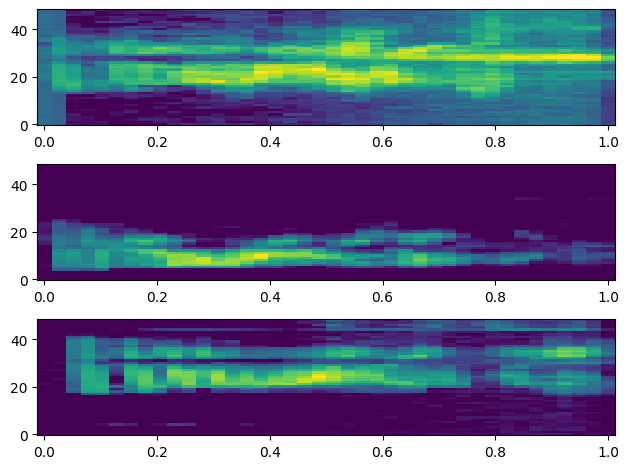

In [13]:
max_target_examples = 3
target_count = 0
target = tf.constant(0)
plt.Figure(figsize=(10,4))
for dat in ds_train.unbatch():
  # label_string = dat[1].numpy().decode('utf8')
  if dat[1] == target:
    target_count += 1
    ax = plt.subplot(max_target_examples, 1, target_count)
    # display.display(display.Audio(dat[0].numpy(), rate=16000))

    log_spec = dat[0].numpy()
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, 1.0, num=width, dtype=float)
    Y = range(height)
    ax.pcolormesh(X, Y, np.squeeze(log_spec))
    if target_count >= max_target_examples:
      break
plt.tight_layout()

In [14]:
## look at the label breakdown in the training set
# print(count_labels(ds_train))

## current count_labels is very slow.  some scratch code here towards
## implementing a faster one by converting labels to one-hot and then summing.
# tf.one_hot(indices, depth)
# ds_1hot = ds_train.map(lambda dat: tf.one_hot(dat[1], 3))
# xx = iter(ds_1hot).next()


## Build and Train Model

In [15]:
# during development, to reload the models module w/o restarting the kernel
# import importlib
# importlib.reload(models)

In [16]:
if load_pretrained_model:
  print(f"Loading pretrained model from {pretrained_model_path}")
  model = keras.models.load_model(pretrained_model_path)
else:
  print(f"Building model from scratch")
  model = models.get_model(args=Flags) # compile step is done inside get_model()

Loading pretrained model from trained_models/str_ww_model.h5


In [17]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 49, 40)]          0         
                                                                 
 tf.expand_dims (TFOpLambda)  (None, 49, 1, 40)        0         
                                                                 
 depthwise_conv2d (Depthwise  (None, 45, 1, 40)        200       
 Conv2D)                                                         
                                                                 
 conv2d (Conv2D)             (None, 45, 1, 128)        5120      
                                                                 
 batch_normalization (BatchN  (None, 45, 1, 128)       512       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 45, 1, 128)        0     

In [18]:
if not load_pretrained_model:
  callbacks = util.get_callbacks(args=Flags)
  train_hist = model.fit(ds_train, validation_data=ds_val, callbacks=callbacks,
                         epochs=Flags.epochs)

In [19]:
if save_model:
  model.save('trained_models/str_ww_model_nb.h5')

In [20]:
if not load_pretrained_model:
  plt.subplot(2,1,1)
  plt.semilogy(train_hist.epoch, train_hist.history['loss'], train_hist.history['val_loss'])
  plt.legend(['training', 'validation'])
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.subplot(2,1,2)
  plt.plot(train_hist.epoch, train_hist.history['sparse_categorical_accuracy'], train_hist.history['val_sparse_categorical_accuracy'])
  plt.legend(['training', 'validation'])
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')


In [21]:
model.evaluate(ds_val)
model.evaluate(ds_test)

111/111 [==============================] - 7s 61ms/step - loss: 0.2213 - sparse_categorical_accuracy: 0.9209


[0.22133858501911163, 0.9208541512489319]

In [22]:
label_list = ['marvin', 'silent', 'other']
model_out = model.predict(ds_val)
model_out = np.squeeze(model_out)
y_pred_val = np.argmax(model_out, axis=1)

y_true_val = np.nan*np.zeros(y_pred_val.shape[0])
for i,dat in enumerate(ds_val.unbatch()):
  y_true_val[i] = dat[1]

acc = sum(y_pred_val == y_true_val) / len(y_true_val)
print(f'Validation set accuracy: {acc:.1%}')

113/113 [==============================] - 5s 43ms/step
Validation set accuracy: 81.9%


In [23]:
# ds_train = ds_train.unbatch().batch(1)

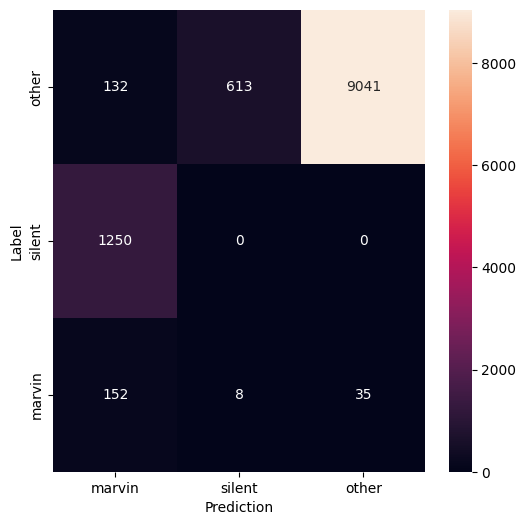

In [24]:

confusion_mtx = tf.math.confusion_matrix(y_true_val, y_pred_val) 
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_mtx, xticklabels=label_list, yticklabels=label_list, 
            annot=True, fmt='g')
plt.gca().invert_yaxis() # flip so origin is at bottom left
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Post-Training Quantization

In [25]:
num_calibration_steps = 5
tfl_file_name = "strm_ww_int8.tflite"

# converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
if True: 
  # If we omit this block, we'll get a floating-point TFLite model,
  # with this block, the weights and activations should be quantized to 8b integers, 
  converter.optimizations = [tf.lite.Optimize.DEFAULT]

  ds_calibration = ds_val.unbatch().batch(1).take(num_calibration_steps)
  def representative_dataset_gen():
    for next_spec, label in ds_calibration:
      yield [next_spec] 
    
  converter.representative_dataset = representative_dataset_gen
  converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8] # use this one
  # converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]

  converter.inference_input_type = tf.int8  # or tf.uint8; should match dat_q in eval_quantized_model.py
  converter.inference_output_type = tf.int8  # or tf.uint8

tflite_quant_model = converter.convert()

with open(tfl_file_name, "wb") as fpo:
  fpo.write(tflite_quant_model)
print(f"Wrote to {tfl_file_name}")
!ls -l $tfl_file_name

INFO:tensorflow:Assets written to: /tmp/tmpct4g4j45/assets


INFO:tensorflow:Assets written to: /tmp/tmpct4g4j45/assets
/usr/local/lib/python3.8/dist-packages/tensorflow/lite/python/convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2024-02-10 14:06:41.406209: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2024-02-10 14:06:41.406248: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
fully_quantize: 0, inference_type: 6, input_inference_type: 9, output_inference_type: 9


Wrote to strm_ww_int8.tflite
-rw-r--r-- 1 jeremy jeremy 62736 Feb 10 14:06 strm_ww_int8.tflite


#### Test Quantized Interpreter on One Spectrogram

In [26]:
interpreter = tf.lite.Interpreter(model_path=tfl_file_name)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
input_shape = input_details[0]['shape']
output_data = []
labels = []
input_scale, input_zero_point = input_details[0]["quantization"]

In [27]:
spec, label = next(ds_val.unbatch().batch(1).take(1).as_numpy_iterator())

spec_q = np.array(spec/input_scale + input_zero_point, dtype=np.int8)
print(f"min = {np.min(spec_q)}, max = {np.max(spec_q)}")

interpreter.set_tensor(input_details[0]['index'], spec_q)
interpreter.invoke()
out_vec = interpreter.get_tensor(output_details[0]['index'])
print(out_vec)
pred_label = np.argmax(out_vec[0])
print(f"True label = {label}. Output = {out_vec}.  Predicted label = {pred_label}")

min = -128, max = 123
[[  4   1 111]]
True label = [2]. Output = [[  4   1 111]].  Predicted label = 2


#### Now Measure Quantized Accuracy on Validation Set

In [28]:
predictions = []
labels = []
# num_test_samples = 100

eval_ds = ds_val # ds_val OR ds_train OR ds_test

for next_spec, next_label in eval_ds.unbatch().batch(1): # .take(num_test_samples):    
  spec_q = np.array(next_spec/input_scale + input_zero_point, dtype=np.int8)
  
  interpreter.set_tensor(input_details[0]['index'], spec_q)
  interpreter.invoke()
  # The function `get_tensor()` returns a copy of the tensor data.
  # Use `tensor()` in order to get a pointer to the tensor.
  predictions.append(np.argmax(interpreter.get_tensor(output_details[0]['index'])))
  labels.append(next_label[0])

predictions = np.array(predictions)
labels = np.array(labels)
num_correct = np.sum(labels == predictions)
acc = num_correct / len(labels)
print(f"Accuracy = {acc:5.3f} ({num_correct}/{len(labels)})")


Accuracy = 0.827 (9285/11231)


As of 10 Feb 2024, the quantized accuracy on the training set is 83% and 83% on the validation set.

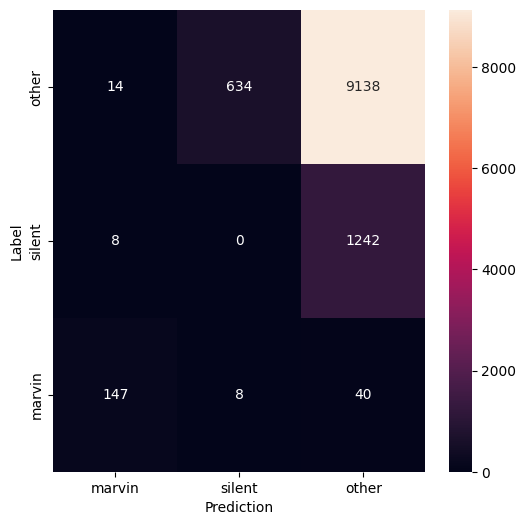

In [29]:
  
confusion_mtx = tf.math.confusion_matrix(labels, predictions) 
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_mtx, xticklabels=label_list, yticklabels=label_list, 
            annot=True, fmt='g')
plt.gca().invert_yaxis() # flip so origin is at bottom left
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Run Model on Long Waveform

In [30]:
if streaming_config['musan_path'] is None or len(streaming_config['musan_path']) == 0:
  raise RuntimeError("Stopping before the long-wave test, which requires the musan dataset in streaming_config['musan_path']")

In [31]:
def trim_and_normalize(wav_in, rel_thresh):
  """
  Trims leading and trailing 'quiet' segments, where quiet is defined as 
  less than rel_thresh*max(wav_in).
  Then scales such that RMS of trimmed wav = 1.0
  """
  idx_start = np.min(np.nonzero(ww_wav > np.max(ww_wav)*rel_thresh))
  idx_stop  = np.max(np.nonzero(ww_wav > np.max(ww_wav)*rel_thresh))
  
  wav_out = wav_in[idx_start:idx_stop]
  wav_out = wav_out / np.std(wav_out) 
  return wav_out

In [32]:

Flags.variable_length=True
model_tv = models.get_model(args=Flags)
Flags.variable_length=False
# transfer weights from trained model into variable-length model
model_tv.set_weights(model.get_weights())

DS TCN model for streaming invoked
Input shape = [None, 40]


In [33]:
rel_thresh = 0.05 # trim out leading/trailing space with less than rel_thresh*max(waveform)

model_settings = models.prepare_model_settings(label_count, Flags)
samp_freq = model_settings['sample_rate']

background_wav_file = os.path.join(streaming_config['musan_path'], 
                                   'noise/free-sound/noise-free-sound-0048.wav'
                                  )


ww_files = ['marvin/cce7416f_nohash_0.wav',
            'marvin/321aba74_nohash_0.wav',
            'marvin/fcb25a78_nohash_0.wav'
           ]

insertion_secs = [1.5, 3.5, 5.0]
# snr_levels = [2.0, 1.0, 0.5]
snr_levels = [20.0, 5.0, 1.0]

for i in range(len(ww_files)):
  ww_files[i] = os.path.join(Flags.data_dir, ww_files[i])


In [34]:
bg_sampling_freq, long_wav = wavfile.read(background_wav_file)
assert bg_sampling_freq == samp_freq
long_wav = long_wav / np.std(long_wav) # normalize to RMS = 1.0

long_wav = long_wav[0:10*samp_freq]

# long_wav = long_wav * 0.0 # uncomment to zero out background noise

ww_present = np.nan*np.zeros(long_wav.shape)

for i in range(len(ww_files)):
  ww_sampling_freq, ww_wav = wavfile.read(ww_files[i])
  assert int(ww_sampling_freq) == samp_freq
  index = int(insertion_secs[i] * samp_freq)
  
  ww_wav = trim_and_normalize(ww_wav, rel_thresh)
  assert index+len(ww_wav) < len(long_wav)
  
  long_wav[index:index+len(ww_wav)] += snr_levels[i]*ww_wav
  ww_present[index:index+len(ww_wav)] = 1

model_settings_long = model_settings.copy() #.update({'desired_samples':len(long_wav)})
model_settings_long.update({'desired_samples':len(long_wav)})

long_wav = long_wav / np.max(np.abs(long_wav)) # scale into [-1.0, +1.0] range
feature_extractor_long = get_preprocess_audio_func(model_settings_long, is_training=False)
long_spec = feature_extractor_long({'audio':long_wav})['audio'].numpy()

print(f"Long waveform shape = {long_wav.shape}, spectrogram shape = {long_spec.shape}")


Long waveform shape = (160000,), spectrogram shape = (499, 40)


In [35]:
display.display(display.Audio(long_wav, rate=16000))

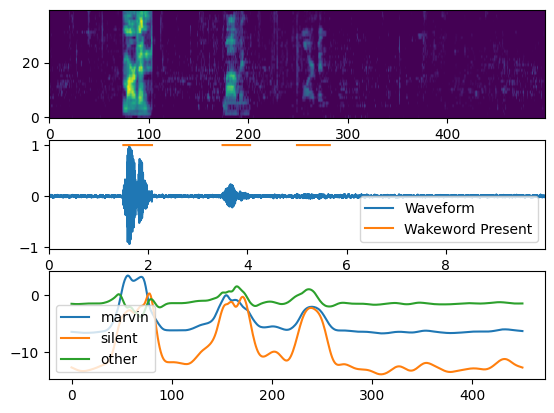

In [36]:
plt.subplot(3,1,1)
plt.imshow(long_spec.T, origin="lower", aspect='auto')

plt.subplot(3,1,2)
t = np.arange(len(long_wav))/samp_freq
plt.plot(t, long_wav, t, ww_present)
plt.xlim([np.min(t), np.max(t)])
plt.legend(['Waveform', 'Wakeword Present'], loc='lower right')
plt.subplot(3,1,3)

yy = model_tv(np.expand_dims(long_spec, 0))[0].numpy()
# plt.plot(yy)
plt.plot(yy[:])
plt.legend(label_list)

In [37]:
raise RuntimeError("Not an error -- just stop here")

RuntimeError: Not an error -- just stop here

## Scratch Space
